# Dependencies

New Environment Created: caa env
Packages: Python 3.7

Necessary packages: folium, sklearn, seaborn, matplotlib

# Collect Data

Data were collected from the Data.gov site with the urls:

List of every arrest in NYC going back to 2006 through the end of the previous calendar year.
https://catalog.data.gov/dataset/nypd-arrests-data-historic

https://catalog.data.gov/dataset/nypd-shooting-incident-data-historic

The data can be exported in many formats including JSON and XML, however CSV offered the most raw source of data and was therefore selected to begin analysis.

At the time of writing data.gov did not offer a streaming or RESTful endpoint for this data to be remotely gathered, therefore the raw source file was downloaded from data.gov then uploaded to this project as NYPD_Shooting_Incident_Data_Historic.csv.

In [1]:
source_arrest_file = "NYPD_Arrests_Data_Historic.csv"
source_shooting_file = "NYPD_Shooting_Incident_Data_Historic.csv"

# Imports 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import random

import folium
from shapely.geometry import Point, Polygon

import sklearn
import seaborn as sns

%matplotlib inline

In [3]:
# experiment reproducibility 
# print(str(int(time.time())))
# 1574546920

In [4]:
random.seed(1574546920)

In [5]:
arrest_df = pd.read_csv(source_arrest_file, dtype=str)
shooting_df = pd.read_csv(source_shooting_file, dtype={'PER_AGE_GROUP': str})

# Exploratory Data Analysis

First we will observe the shape of the data and sample the first observation to understand what type of variables and the initial condition of the data.

In [6]:
arrest_df.shape

(4798339, 18)

In [7]:
shooting_df.shape

(20659, 18)

In [8]:
arrest_df.head(1)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,173130602,12/31/2017,566,"MARIJUANA, POSSESSION",678,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0,25-44,M,BLACK,1063056.0,207463.0,40.73577180300003,-73.715638255


In [9]:
allowed_ages = ['25-44', '18-24','<18','45-64','65+', 'UNKNOWN']
arrest_df['AGE_GROUP'] = [a if a in allowed_ages else np.nan for a in arrest_df.AGE_GROUP]
shooting_df['PERP_AGE_GROUP'] = [a if a in allowed_ages else np.nan for a in shooting_df.PERP_AGE_GROUP]

In [10]:
shooting_df.head(1)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,169180023,09/09/2017,3:57:00,STATEN ISLAND,120,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,959975,171772,40.638126,-74.087467


Initial review of the datasets. The arrest data has 18 variables with 4,798,339 observations while the shooting data has 18 variables with only 20,659 observations. 

Both datasets contain an incident date (ARREST_DATE and OCCUR_DATE) but only the shooting data contains a time (OCCUR_TIME). 

Both datasets contain a JURISDICTION_CODE.

Both datesets include a precinct (ARREST_PRECINCT and PRECINCT). 

Both datasets contain a borough (ARREST_BORO and BORO), however the arrest data's borough data is abstracted. 

Both datasets contain a lat long for the event.

Next we will turn the date of event into a datetime variable so we can review the events over time. 

In [11]:
arrest_df['date'] = pd.to_datetime(arrest_df.ARREST_DATE)
shooting_df['date'] = pd.to_datetime(shooting_df.OCCUR_DATE)

We will transcode the Boroughs from their single letter code to the full name.

In [12]:
boro_key = {'Q': 'QUEENS', 'K': 'BRONX', 'M':'MANHATTAN', 'S':'STATEN ISLAND', 'B': 'BROOKLYN', np.nan: np.nan}
arrest_df['BORO'] = [boro_key[k] for k in arrest_df.ARREST_BORO]

Next we will review which of the variable in each dataset have mission values.

In [13]:
for cat in arrest_df:
    print(cat + " nan values: " + str(arrest_df[cat].isna().sum()))

ARREST_KEY nan values: 0
ARREST_DATE nan values: 0
PD_CD nan values: 220
PD_DESC nan values: 8870
KY_CD nan values: 8870
OFNS_DESC nan values: 8870
LAW_CODE nan values: 196
LAW_CAT_CD nan values: 16103
ARREST_BORO nan values: 8
ARREST_PRECINCT nan values: 0
JURISDICTION_CODE nan values: 10
AGE_GROUP nan values: 190
PERP_SEX nan values: 0
PERP_RACE nan values: 0
X_COORD_CD nan values: 1
Y_COORD_CD nan values: 1
Latitude nan values: 1
Longitude nan values: 1
date nan values: 0
BORO nan values: 8


In [14]:
clean_arrest_df = arrest_df.dropna()

In [15]:
for cat in shooting_df:
    print(cat + " nan values: " + str(shooting_df[cat].isna().sum()))

INCIDENT_KEY nan values: 0
OCCUR_DATE nan values: 0
OCCUR_TIME nan values: 0
BORO nan values: 0
PRECINCT nan values: 0
JURISDICTION_CODE nan values: 1
LOCATION_DESC nan values: 11715
STATISTICAL_MURDER_FLAG nan values: 0
PERP_AGE_GROUP nan values: 6860
PERP_SEX nan values: 6823
PERP_RACE nan values: 6823
VIC_AGE_GROUP nan values: 0
VIC_SEX nan values: 0
VIC_RACE nan values: 0
X_COORD_CD nan values: 0
Y_COORD_CD nan values: 0
Latitude nan values: 0
Longitude nan values: 0
date nan values: 0


With regards to relevant data about the activities captured in the data: 

The arrest dataset has slightly under 9000 or ~.2% mission data. 

The shooting dataset has 6857 mission values, or ~33% mission data, however of note those values are missing from the perp data fields rather than the victim of crime. This may mean those values were redacted by a judge or other data protection mechanisms.


In [16]:
clean_shooting_df = shooting_df.dropna()

In [17]:
#arrest_df.groupby('PD_DESC').agg({'ARREST_KEY': pd.Series.nunique})
arrest_df.groupby('PD_DESC').count()['ARREST_KEY'].reset_index()

,PD_DESC,ARREST_KEY
0,"A.B.C.,FALSE PROOF OF AGE",391
1,ABORTION 1,10
2,"ABORTION 2, 1, SELF",1
3,ABSCONDING FROM WORK RELEASE 2,27
4,"ACCOSTING,FRAUDULENT",2139
...,...,...
346,"WEAPONS,DISPOSITION OF",17
347,"WEAPONS,MFR,TRANSPORT,ETC.",252
348,"WEAPONS,PROHIBITED USE",36
349,"WEAPONS,PROHIBITED USE IMITATION PISTOL",5


We note there are 351 unique crime categories - but there are multiple derivatives of the same types of crime such as crimes involving weapons or crimes involving tresspassing. 

If we identify the top 10 most common crimes we can start to understand the dataset more.

In [18]:
top_10_arrests = arrest_df.groupby('PD_DESC').count()['ARREST_KEY'].sort_values(ascending=False).head(10)
display(top_10_arrests)

PD_DESC
MARIJUANA, POSSESSION 4 & 5                   422358
ASSAULT 3                                     376001
THEFT OF SERVICES, UNCLASSIFIED               303359
CONTROLLED SUBSTANCE, POSSESSION 7            278083
NY STATE LAWS,UNCLASSIFIED VIOLATION          225678
LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED    188347
TRAFFIC,UNCLASSIFIED INFRACTION               165647
ASSAULT 2,1,UNCLASSIFIED                      150823
STOLEN PROPERTY 3,POSSESSION                  149877
ROBBERY,UNCLASSIFIED,OPEN AREAS               143263
Name: ARREST_KEY, dtype: int64

We see that Marijuana Possession 4 and 5 are the most previlent crime. From outside research these are both Misdemeanors and including possession of More then 25g - 2oz. and More than 2-8oz. Possession 5+ as seen above area felony drug offenses.

Source: http://ypdcrime.com/penal.law/marijuana-penalties.htm

If we sort by the <i>least</i> common crimes:

In [19]:
arrest_df.groupby('PD_DESC').count()['ARREST_KEY'].sort_values().head(15)

PD_DESC
WOUNDS,REPORTING OF                           1
ABORTION 2, 1, SELF                           1
USING SLUGS, 2ND                              1
FAC. SEXUAL OFFENSE W/CONTROLLED SUBSTANCE    1
LOITERING FOR PROSTITUTION OR                 1
LOITERING,BEGGING                             1
MANUFATURE, TRANSPORT, DEFACE, ETC...         1
MARRIAGE,OFFENSES AGAINST,UNCLASSIFIED        1
RIGHT OF WAY,PEDESTRIAN                       1
PUBLIC HEALTH LAW,UNCLASSIFIED                1
EXHIBITION,OFFENSIVE                          1
MISCHIEF,CRIMINAL     UNCLASSI                1
PEDESTRIAN - WALK/DO NOT WALK                 1
WEAPONS DISPOSITION OF                        2
AGRICULTURE & MARKETS LAW,UNCL                2
Name: ARREST_KEY, dtype: int64

# Comparing PD Description and Offense Description

Now for each precinct I would like to see the most prevelant arrest data by both PD Description and Offense Description.

In [20]:
df_agg = arrest_df.sort_values(['ARREST_PRECINCT']).groupby(['ARREST_PRECINCT','PD_DESC']).agg({'count',sum})
g = df_agg['ARREST_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))

r1 = pd.DataFrame(res).reset_index(level=-1, drop=False)

df_agg = arrest_df.sort_values(['ARREST_PRECINCT']).groupby(['ARREST_PRECINCT','OFNS_DESC']).agg({'count',sum})
g = df_agg['ARREST_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))

r2 = pd.DataFrame(res).reset_index(level=-1, drop=False)

pd.concat([r1,r2], axis=1)

,PD_DESC,count,OFNS_DESC,count
ARREST_PRECINCT,,,,
1,"NY STATE LAWS,UNCLASSIFIED MISDEMEANOR",6899,OTHER STATE LAWS (NON PENAL LAW),7040
10,ASSAULT 3,2440,DANGEROUS DRUGS,7321
100,ASSAULT 3,2582,DANGEROUS DRUGS,3329
101,"MARIJUANA, POSSESSION 4 & 5",5466,DANGEROUS DRUGS,10311
102,ASSAULT 3,5786,DANGEROUS DRUGS,7151
...,...,...,...,...
84,"THEFT OF SERVICES, UNCLASSIFIED",8004,OTHER OFFENSES RELATED TO THEFT,8012
88,"THEFT OF SERVICES, UNCLASSIFIED",3288,DANGEROUS DRUGS,6978
9,"STOLEN PROPERTY 3,POSSESSION",4166,DANGEROUS DRUGS,11270


From this comparison we can assess that there is a decrepency between the PD and Offense description. From the source of the data the PD is more gradular and of a higher fidelity than the Offense Description.

# Geo Data View

We are going to visually plot the arrest data. We know that the >4M points would create a visually dense map so we will limit the information to just those top 10 we created earlier.

First we will quickly look at the Latitude and Longitude data to assess if there are any outliers or anomalies. This is only useful with the context that the general area of NYC is covered between Latitude ~40~67 and Longitude -74.3~-73.6.

In [21]:
np.warnings.filterwarnings('ignore')

{'whiskers': [<matplotlib.lines.Line2D at 0x238980e2e08>,
 'caps': [<matplotlib.lines.Line2D at 0x2389b289848>,
 'boxes': [<matplotlib.lines.Line2D at 0x2389b289808>],
 'medians': [<matplotlib.lines.Line2D at 0x2389a8deb88>],
 'fliers': [<matplotlib.lines.Line2D at 0x2389b250d08>],
 'means': []}

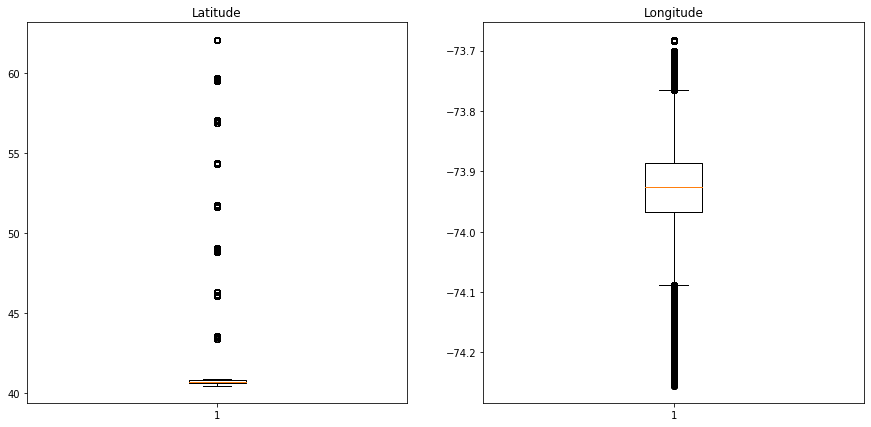

In [22]:
a = [float(i) for i in arrest_df.Latitude]
a = pd.Series(a).dropna()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.set_title('Latitude')
ax1.boxplot(a)

a = [float(i) for i in arrest_df.Longitude]
a = pd.Series(a).dropna()
ax2.set_title('Longitude')
ax2.boxplot(a)

#### Geoplotting Data

We will use Folium to plot the data on a 2D map. Our intent is to determine if there are major clusters of particular crimes, or areas where crimes are less prevalent.

In [23]:
import folium

crime_colors = ['black', 'm','grey','firebrick','hotpink','green','orangered','goldenrod', 'red','lightseagreen']
crime_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue']
m = folium.Map(location=[40.758896, -73.985130], zoom_start=10)

#

for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        for index, s in sub[0:100].iterrows():
            m.add_child(folium.Marker(location=[s.Latitude, s.Longitude],popup=(folium.Popup(arrest_type)),icon=folium.Icon(color=crime_colors[i],icon_color='black')))
        
m
#map.add_child(fg)

#### Observations from Geoplotted Data

It does not appear that there are any areas with demonstrably more of a single type of crime.

# Arrest Data Timeline

We will plot the data across time to look for trends.

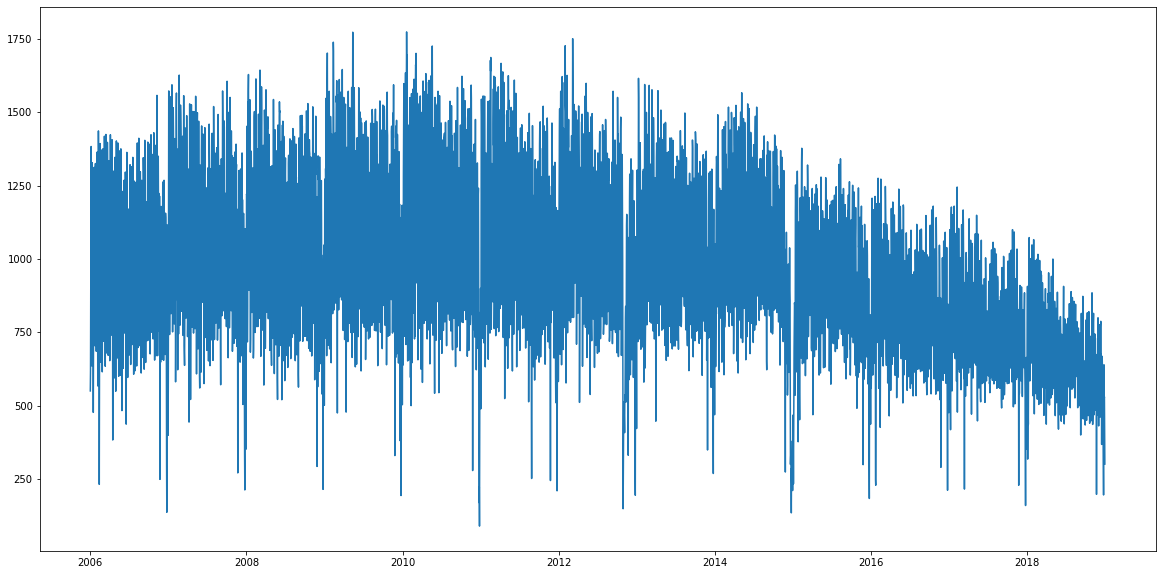

In [24]:
#arrest_df['date'] = pd.to_datetime(arrest_df.ARREST_DATE)
t = arrest_df.groupby('date').count()['ARREST_KEY']
plt.figure(figsize=(20,10))
plt.plot(t)
plt.show()

#### Timeline observations

From the time series plot we can observe a slight downward trend in the overall arrest between 2006 and 2019.

In [25]:
t = arrest_df.groupby(['date', 'PD_DESC']).count().reset_index()

z = ['ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']

#### Overall plot of the data

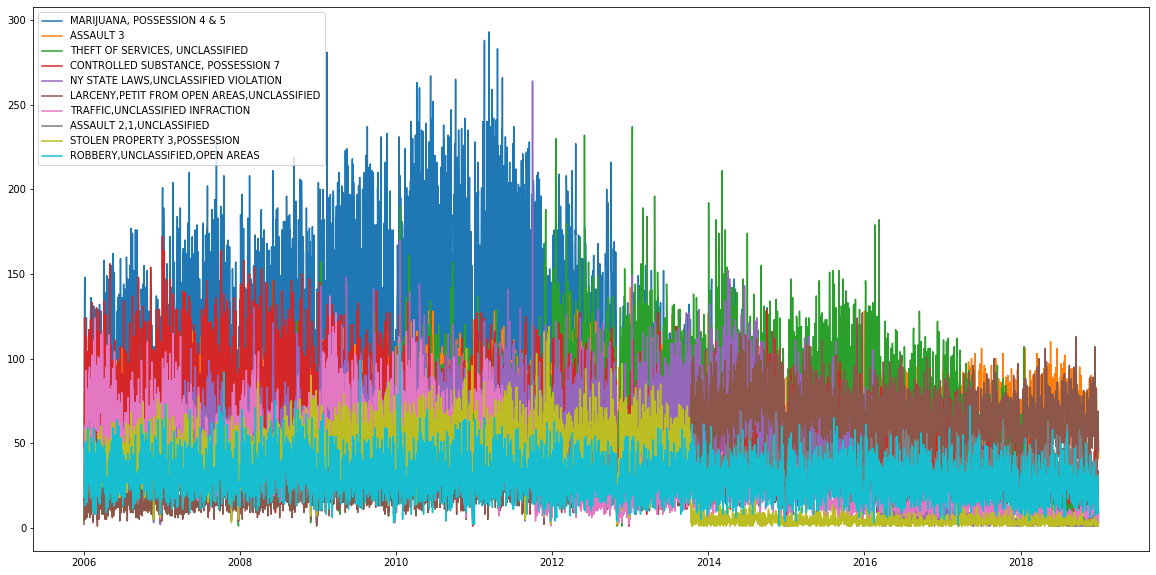

In [26]:
plt.figure(figsize=(20,10))
z = ['PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']

for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        t = sub.groupby(['date']).count().reset_index().drop(z, axis=1).dropna()
        t['date'] = pd.to_datetime(t['date'], unit='s')
        t['mdate'] = [mdates.date2num(d) for d in t['date']]
        plt.plot(t.date, t.ARREST_KEY, label=arrest_type)
        
plt.legend(loc="upper left")
plt.show()
plt.close()


#### Time series lines

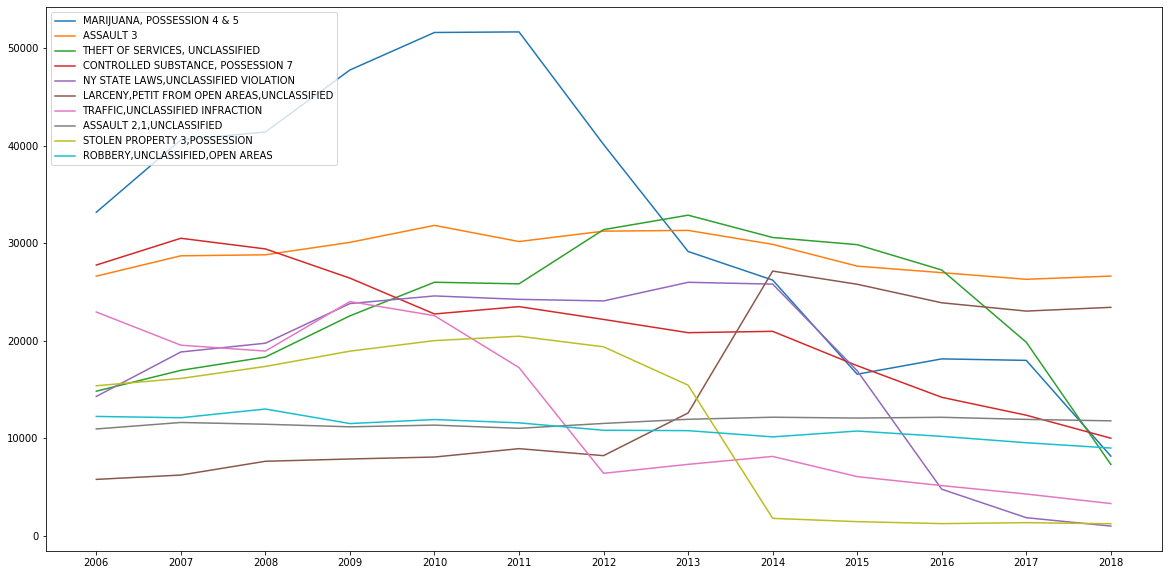

In [27]:
plt.figure(figsize=(20,10))
z = ['date','PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']




for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        sub['year'] = [str(y)[-4:] for y in sub.ARREST_DATE]
        t = sub.groupby(['year']).count().reset_index().drop(z, axis=1).dropna()
        t.set_index('year', inplace=True)
        #t['date'] = pd.to_datetime(t['date'], unit='s')
        #t['mdate'] = [mdates.date2num(d) for d in t['date']]
        #t.plot(label=arrest_type)
        plt.plot(t.ARREST_KEY, label=arrest_type)
        
plt.legend(loc="upper left")
plt.show()
plt.close()


In [28]:
'MARIJUANA, POSSESSION 4 & 5'
sub = clean_arrest_df[clean_arrest_df.PD_DESC == 'MARIJUANA, POSSESSION 4 & 5']
sub['year'] = [str(y)[-4:] for y in sub.ARREST_DATE]

test = sub[sub.year == '2011']
z = ['date','PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']


#### Linear Trendlines

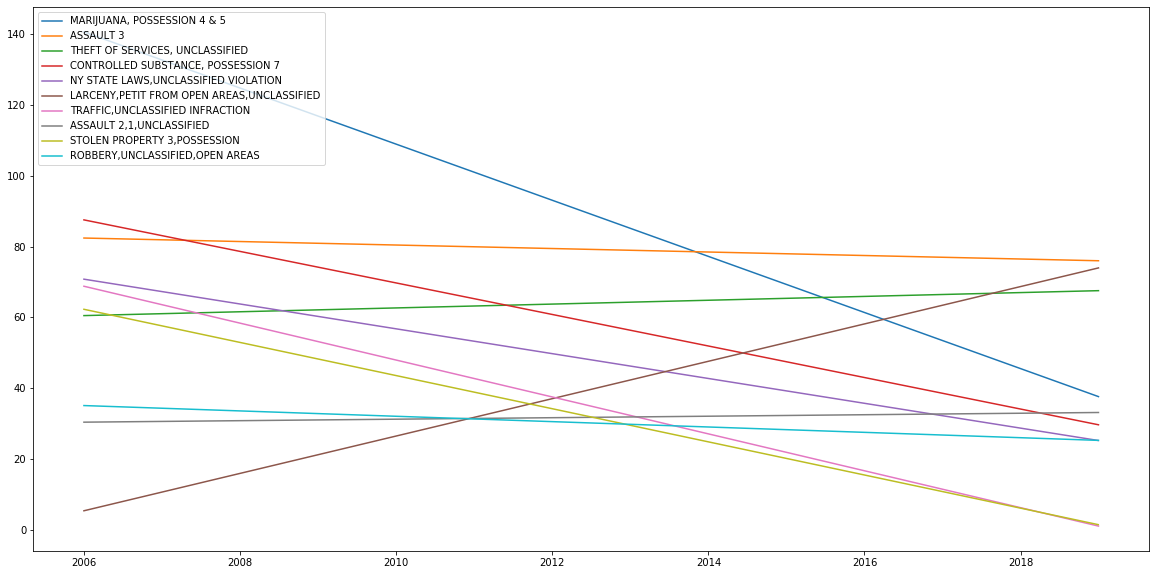

In [29]:
plt.figure(figsize=(20,10))
z = ['PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']

for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        t = sub.groupby(['date']).count().reset_index().drop(z, axis=1).dropna()
        t['date'] = pd.to_datetime(t['date'], unit='s')
        t['mdate'] = [mdates.date2num(d) for d in t['date']]
        za = np.polyfit(t.mdate, t.ARREST_KEY, 1)
        p = np.poly1d(za)
        plt.plot(t.date,p(t.mdate,), label=arrest_type)
        
        #plt.plot(t.date, t.ARREST_KEY, label=arrest_type)

plt.legend(loc="upper left")
plt.show()
plt.close()


### Observations

From the data we see a general downward trend in the overall arrests as well as generally within the top 10 arrest types. That being said we see a steep increase in Larceny from open areas in 2012 and a matching sharp decrease in stolen property 3 in 2013. These could be due to changes in law enforcement tactics or other outside influences. 

# Shooting Data Timeline

### Refresher on Shooting Data

In [30]:
shooting_df.head(5)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,date
0,169180023,09/09/2017,3:57:00,STATEN ISLAND,120,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,959975,171772,40.638126,-74.087467,2017-09-09
1,169180027,09/09/2017,22:15:00,BRONX,50,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK HISPANIC,1011288,255912,40.869061,-73.902242,2017-09-09
2,169180025,09/09/2017,18:35:00,BROOKLYN,79,2.0,MULTI DWELL - PUBLIC HOUS,False,NaN,NaN,NaN,18-24,M,BLACK,999888,193014,40.696450,-73.943607,2017-09-09
3,169180024,09/09/2017,15:20:00,BROOKLYN,67,0.0,NaN,False,18-24,M,BLACK,18-24,M,BLACK,997784,172132,40.639137,-73.951236,2017-09-09
4,169180022,09/09/2017,0:20:00,BROOKLYN,61,2.0,MULTI DWELL - PUBLIC HOUS,False,NaN,NaN,NaN,25-44,M,ASIAN / PACIFIC ISLANDER,1001019,156467,40.596134,-73.939619,2017-09-09


In [31]:
shooting_df.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'PRECINCT',
       'JURISDICTION_CODE', 'LOCATION_DESC', 'STATISTICAL_MURDER_FLAG',
       'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX',
       'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'date'],
      dtype='object')

### Strip out the Year to show trend over time

In [32]:
shooting_df['year'] = [str(y)[-4:] for y in shooting_df.OCCUR_DATE]

#### Identify Precinct with Most Shootings

In [33]:
shooting_count = shooting_df.sort_values(['PRECINCT']).groupby(['PRECINCT']).agg({'count',sum})

#murder_true = murder_true.sort_values(by='PRECINCT').groupby(['PRECINCT']).agg({'count',sum})
g = shooting_count['INCIDENT_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))
res.reset_index().sort_values('count', ascending=False).head(10)


,PRECINCT,count
45,75,1165
44,73,1117
38,67,994
49,79,809
25,44,746
28,47,733
27,46,692
21,40,660
50,81,645
69,113,637


### Identify Precinct with Most Murders

In [34]:
murder_true = shooting_df[shooting_df['STATISTICAL_MURDER_FLAG'] == True]

murder_true = murder_true.sort_values(['PRECINCT']).groupby(['PRECINCT']).agg({'count',sum})

#murder_true = murder_true.sort_values(by='PRECINCT').groupby(['PRECINCT']).agg({'count',sum})
g = murder_true['INCIDENT_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))
res.reset_index().sort_values('count', ascending=False).head(10).set_index('PRECINCT')

,count
PRECINCT,
75,218
73,206
67,192
47,164
79,153
46,135
44,134
81,128
113,127


In [35]:
res.reset_index().sort_values('count', ascending=True).head(10).set_index('PRECINCT')

,count
PRECINCT,
19,2
17,2
68,4
18,4
1,5
20,5
78,6
66,6
123,6


#### Observations

We note form the data that Precinct 75 has the highest number of shootings and the highest number of murders. This could be a good Precinct to conduct influence operations to understand why the abundance of shootings. 

### Plot the number of shootings per year

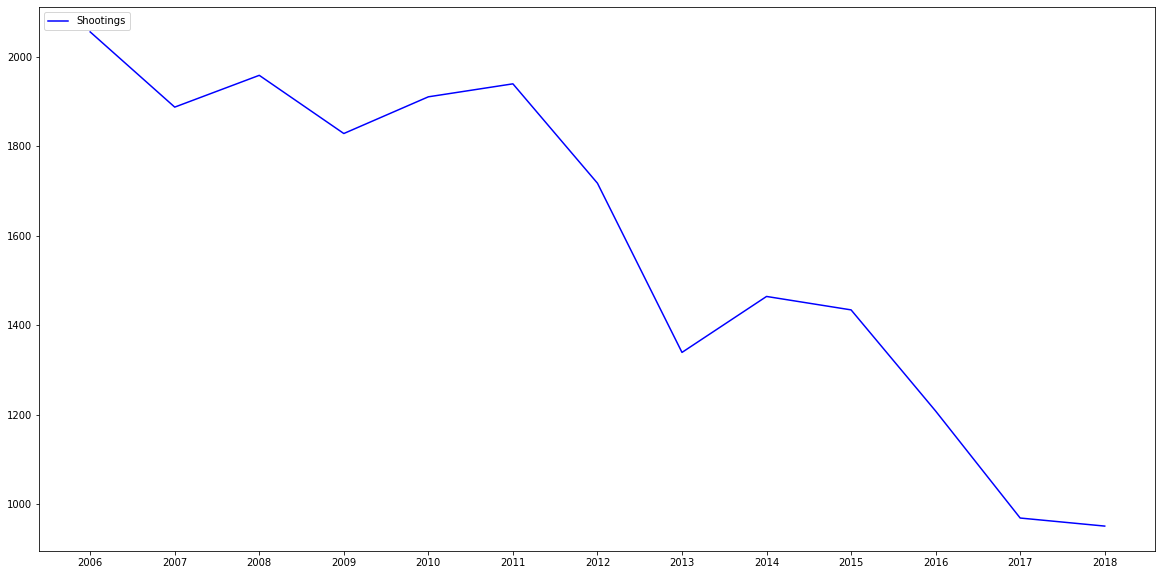

In [36]:
#murder_true = shooting_df[shooting_df['STATISTICAL_MURDER_FLAG'] == True]
#murder_false = shooting_df[shooting_df['STATISTICAL_MURDER_FLAG'] == False]

shooting = shooting_df.groupby(['year']).count().reset_index().dropna()
plt.figure(figsize=(20,10))

plt.plot(shooting.year, shooting.INCIDENT_KEY, color='blue',label='Shootings')

#t[t['STATISTICAL_MURDER_FLAG'] == True].drop('STATISTICAL_MURDER_FLAG',axis=1).plot(color='red',label='Murder')
plt.legend(loc="upper left")
plt.show()
plt.close()
#murder_true = murder_true.sort_values(by='PRECINCT').groupby(['PRECINCT']).agg({'count',sum})
#g = murder_true['INCIDENT_KEY']['count'].groupby(level=0, group_keys=False)
#res = g.apply(lambda x: x.sort_values(ascending=False).head(1))

#### Seperating Shootings which are murder from non-murder

In [37]:

t = shooting_df.groupby(['year', 'STATISTICAL_MURDER_FLAG']).count()['INCIDENT_KEY'].reset_index()
non_murder = t[t['STATISTICAL_MURDER_FLAG'] == False].drop('STATISTICAL_MURDER_FLAG',axis=1).reset_index(drop=True)
murder = t[t['STATISTICAL_MURDER_FLAG'] == True].drop('STATISTICAL_MURDER_FLAG',axis=1).reset_index(drop=True)

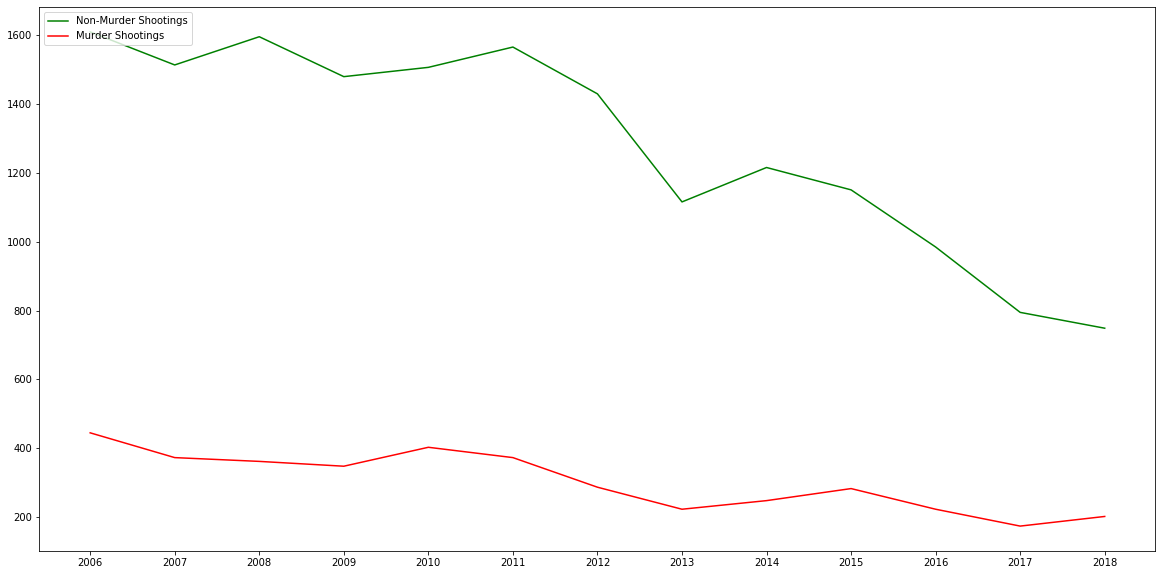

In [38]:
plt.figure(figsize=(20,10))

plt.plot(non_murder.year, non_murder.INCIDENT_KEY, color='green',label='Non-Murder Shootings')
plt.plot(murder.year, murder.INCIDENT_KEY, color='red',label='Murder Shootings')
#t[t['STATISTICAL_MURDER_FLAG'] == True].drop('STATISTICAL_MURDER_FLAG',axis=1).plot(color='red',label='Murder')
plt.legend(loc="upper left")
plt.show()
plt.close()

From the data we see the overall trend in shootings is decreasing with time. The overall shootings is decreasing at a faster rate than the number of murders - which is to be expected as shooting murders are dependant on shootings. 

### Race / Demographics Overview

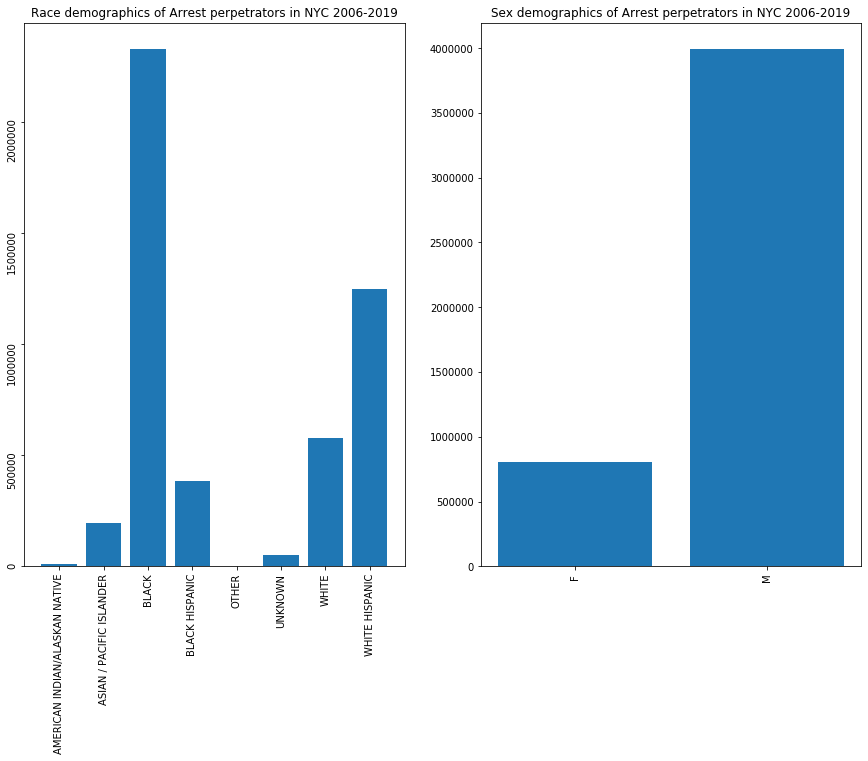

In [39]:
ah = arrest_df.groupby('PERP_RACE').count().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title('Race demographics of Arrest perpetrators in NYC 2006-2019')

ax1.bar(ah['PERP_RACE'], ah['ARREST_KEY'])
ax1.tick_params(labelrotation=90)

ah = arrest_df.groupby('PERP_SEX').count().reset_index()

ax2.set_title('Sex demographics of Arrest perpetrators in NYC 2006-2019')
ax2.bar(ah['PERP_SEX'], ah['ARREST_KEY'])



plt.xticks(rotation='vertical')
plt.show()

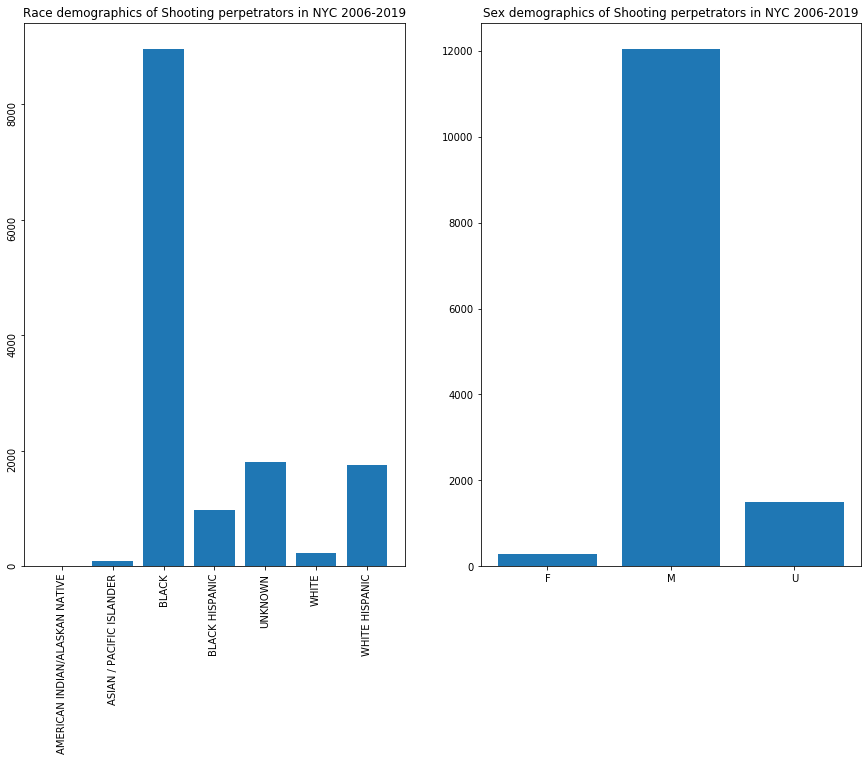

In [40]:
sh = shooting_df.groupby('PERP_RACE').count().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title('Race demographics of Shooting perpetrators in NYC 2006-2019')

ax1.bar(sh['PERP_RACE'], sh['INCIDENT_KEY'])
ax1.tick_params(labelrotation=90)

sh = shooting_df.groupby('PERP_SEX').count().reset_index()

ax2.set_title('Sex demographics of Shooting perpetrators in NYC 2006-2019')
ax2.bar(sh['PERP_SEX'], sh['INCIDENT_KEY'])


plt.show()

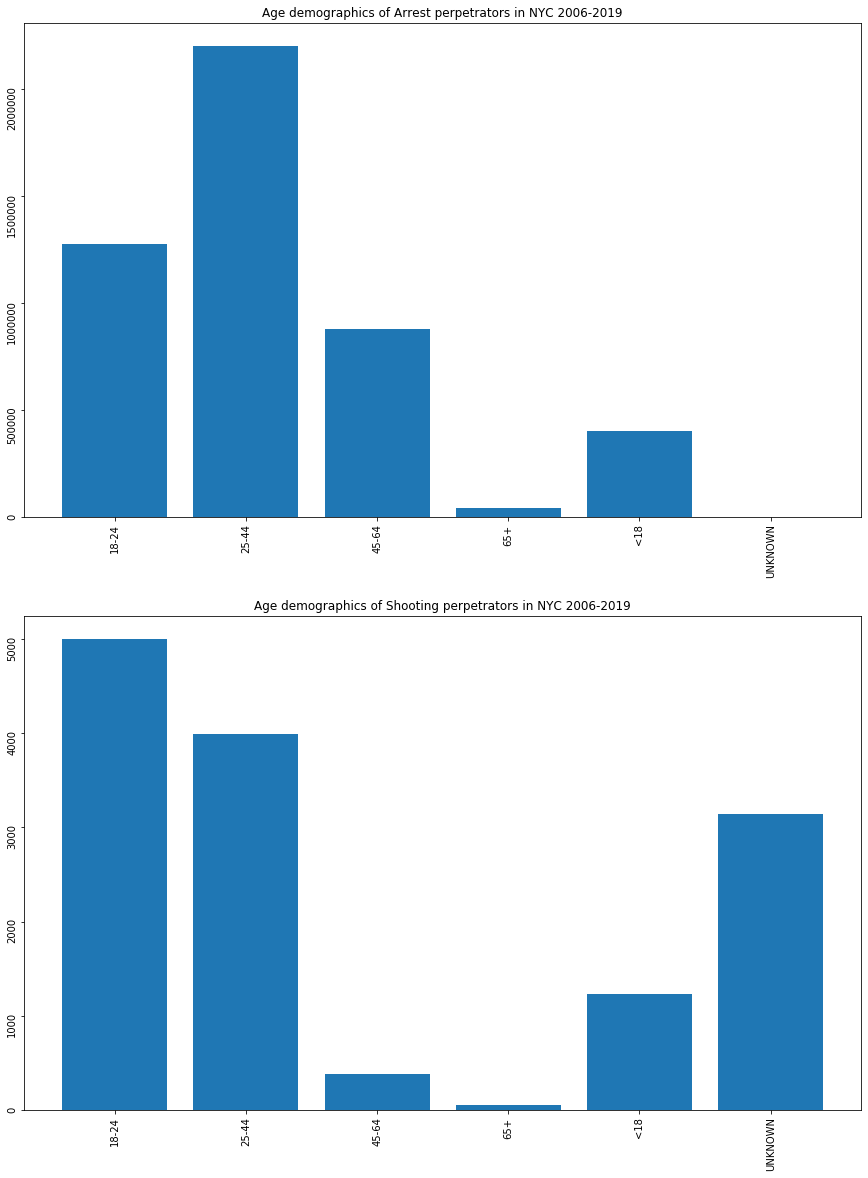

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,20))
ax1.set_title('Age demographics of Arrest perpetrators in NYC 2006-2019')

ah = arrest_df.groupby('AGE_GROUP').count().reset_index()

ax1.bar(ah['AGE_GROUP'], ah['ARREST_KEY'])
ax1.tick_params(labelrotation=90)

sh = shooting_df.groupby('PERP_AGE_GROUP').count().reset_index()

ax2.set_title('Age demographics of Shooting perpetrators in NYC 2006-2019')
ax2.bar(sh['PERP_AGE_GROUP'], sh['INCIDENT_KEY'])
ax2.tick_params(labelrotation=90)

plt.show()

In [42]:
ah = arrest_df.groupby('AGE_GROUP').count()

Next we will show the Boroughs were both ARRESTS and SHOOTINGS occur from both datasets. 

### Borough Overview

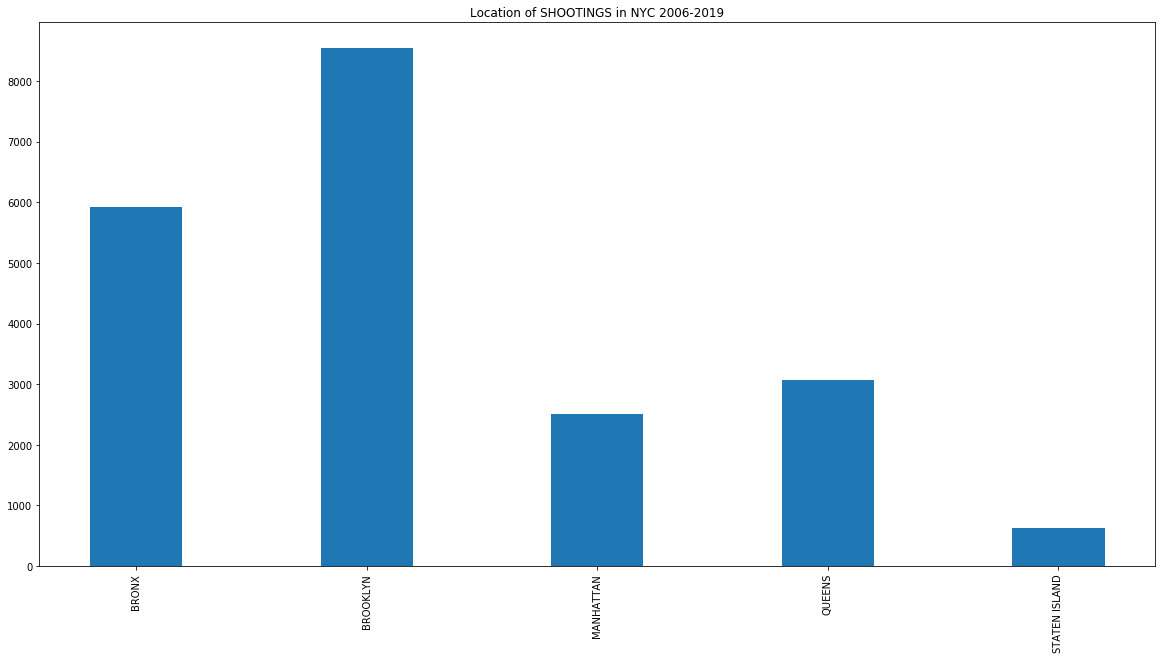

In [44]:
sh = shooting_df.groupby('BORO').count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.title('Location of SHOOTINGS in NYC 2006-2019')
b1 = plt.bar(sh['BORO'], sh['INCIDENT_KEY'], width=0.4, label='shootings', align="center")
plt.show()

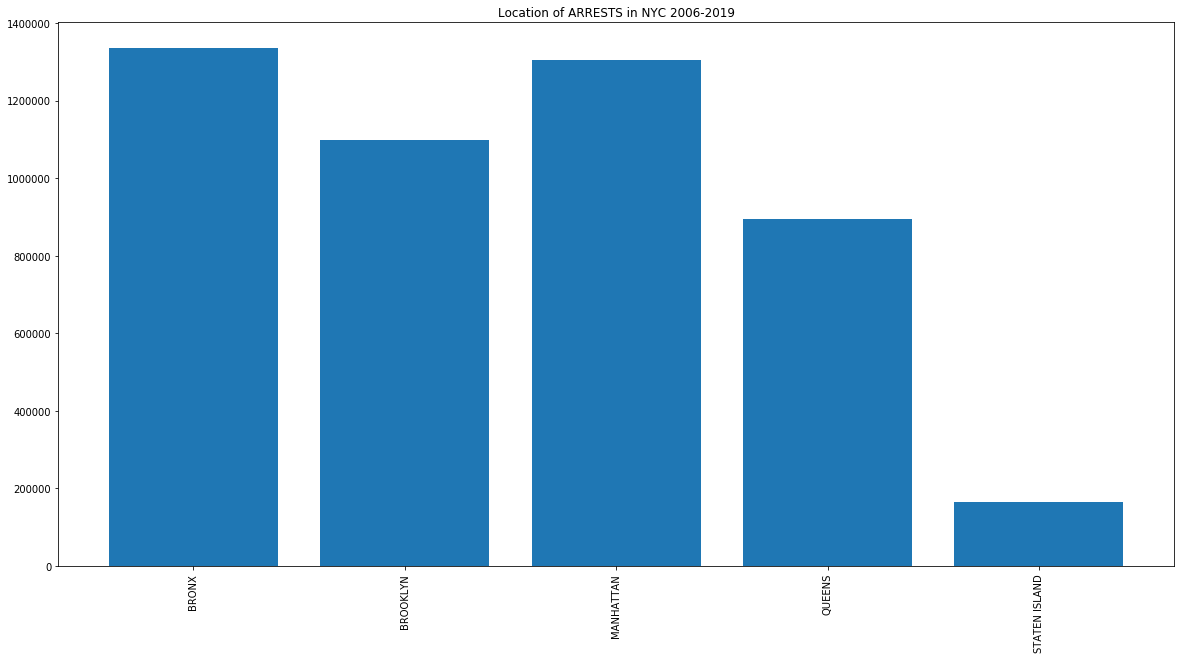

In [45]:
sh = arrest_df.groupby('BORO').count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.title('Location of ARRESTS in NYC 2006-2019')
plt.bar(sh['BORO'], sh['ARREST_KEY'])
plt.show()

The Bronx appears to have a significant amount of both Shootings and Arrests, while there are signficantly less shootings than arrests in Manhattan. This may signifiy the crime in Manhattan is more focused on larceny or other non-violent crimes. 

### Correlation between Shooting Perp Age Group and Borough

# Wizardly Data Prep

After we've done the initial Exploratory Data Analysis we will not begin to prep the data for prediction. 

Our first step is to take all of of the categorical variables, including binary, and one hot encode them. This will increase the dataframe dimentionality, but is required.

We will also convert the datetime variables to epochs and drop non-useful variables. 

In [46]:
# for debugging the data prep pipeline

source_arrest_file = "NYPD_Arrests_Data_Historic.csv"
source_shooting_file = "NYPD_Shooting_Incident_Data_Historic.csv"

arrest_df = pd.read_csv(source_arrest_file)
shooting_df = pd.read_csv(source_shooting_file)

allowed_ages = ['25-44', '18-24','<18','45-64','65+']
arrest_df['AGE_GROUP'] = [a if a in allowed_ages else np.nan for a in arrest_df.AGE_GROUP]

arrest_df['date'] = pd.to_datetime(arrest_df.ARREST_DATE)
shooting_df['date'] = pd.to_datetime(shooting_df.OCCUR_DATE)
boro_key = {'Q': 'QUEENS', 'K': 'BRONX', 'M':'MANHATTAN', 'S':'STATEN ISLAND', 'B': 'BROOKLYN', np.nan: np.nan}
arrest_df['BORO'] = [boro_key[k] for k in arrest_df.ARREST_BORO]

In [47]:
arrest_df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,date,BORO
0,173130602,12/31/2017,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,2017-12-31,QUEENS
1,173114463,12/31/2017,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0.0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,2017-12-31,QUEENS
2,173113513,12/31/2017,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,1.0,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572,2017-12-31,BRONX
3,173113423,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,2017-12-31,MANHATTAN
4,173113421,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,2017-12-31,MANHATTAN


In [48]:
# prep shooting df for magic
# one hot encoding
shooting_dummies = ['BORO', 'PRECINCT','JURISDICTION_CODE','STATISTICAL_MURDER_FLAG','PERP_AGE_GROUP','PERP_SEX','PERP_RACE','VIC_AGE_GROUP','VIC_SEX','VIC_RACE']

for sd in shooting_dummies:
    dummies = pd.get_dummies(shooting_df[sd], prefix = sd)
    shooting_df = pd.concat([shooting_df, dummies], axis=1)
    shooting_df = shooting_df.drop(sd, axis=1)
    
# convert DTG to epoch
shooting_df['date_stamp'] = [int(t.timestamp()) for t in shooting_df.date]
shooting_df = shooting_df.drop(['OCCUR_DATE','OCCUR_TIME', 'date'], axis=1)

# drop non-useful variables
drop_cols = ['LOCATION_DESC', 'X_COORD_CD', 'Y_COORD_CD', 'INCIDENT_KEY']
shooting_df = shooting_df.drop(drop_cols, axis=1)
    
# prep arrest df for magic
# one hot encoding
arrest_dummies = ['PD_DESC', 'OFNS_DESC', 'BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE']

for ad in arrest_dummies:
    dummies = pd.get_dummies(arrest_df[ad], prefix = ad)
    arrest_df = pd.concat([arrest_df, dummies], axis=1)
    arrest_df = arrest_df.drop(ad, axis=1)

# convert DTG to epoch
arrest_df['date_stamp'] = [int(t.timestamp()) for t in arrest_df.date]
arrest_df = arrest_df.drop(['ARREST_DATE', 'date'], axis=1)

# drop non-useful variables
drop_cols = ['ARREST_KEY', 'PD_CD','KY_CD','LAW_CODE','LAW_CAT_CD','X_COORD_CD','Y_COORD_CD','ARREST_BORO']
arrest_df = arrest_df.drop(drop_cols, axis=1)

In [49]:
shooting_df.head()

,Latitude,Longitude,BORO_BRONX,BORO_BROOKLYN,BORO_MANHATTAN,BORO_QUEENS,BORO_STATEN ISLAND,PRECINCT_1,PRECINCT_5,PRECINCT_6,...,VIC_SEX_M,VIC_SEX_U,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_UNKNOWN,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,date_stamp
0,40.638126,-74.087467,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1504915200
1,40.869061,-73.902242,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1504915200
2,40.696450,-73.943607,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1504915200
3,40.639137,-73.951236,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1504915200
4,40.596134,-73.939619,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1504915200


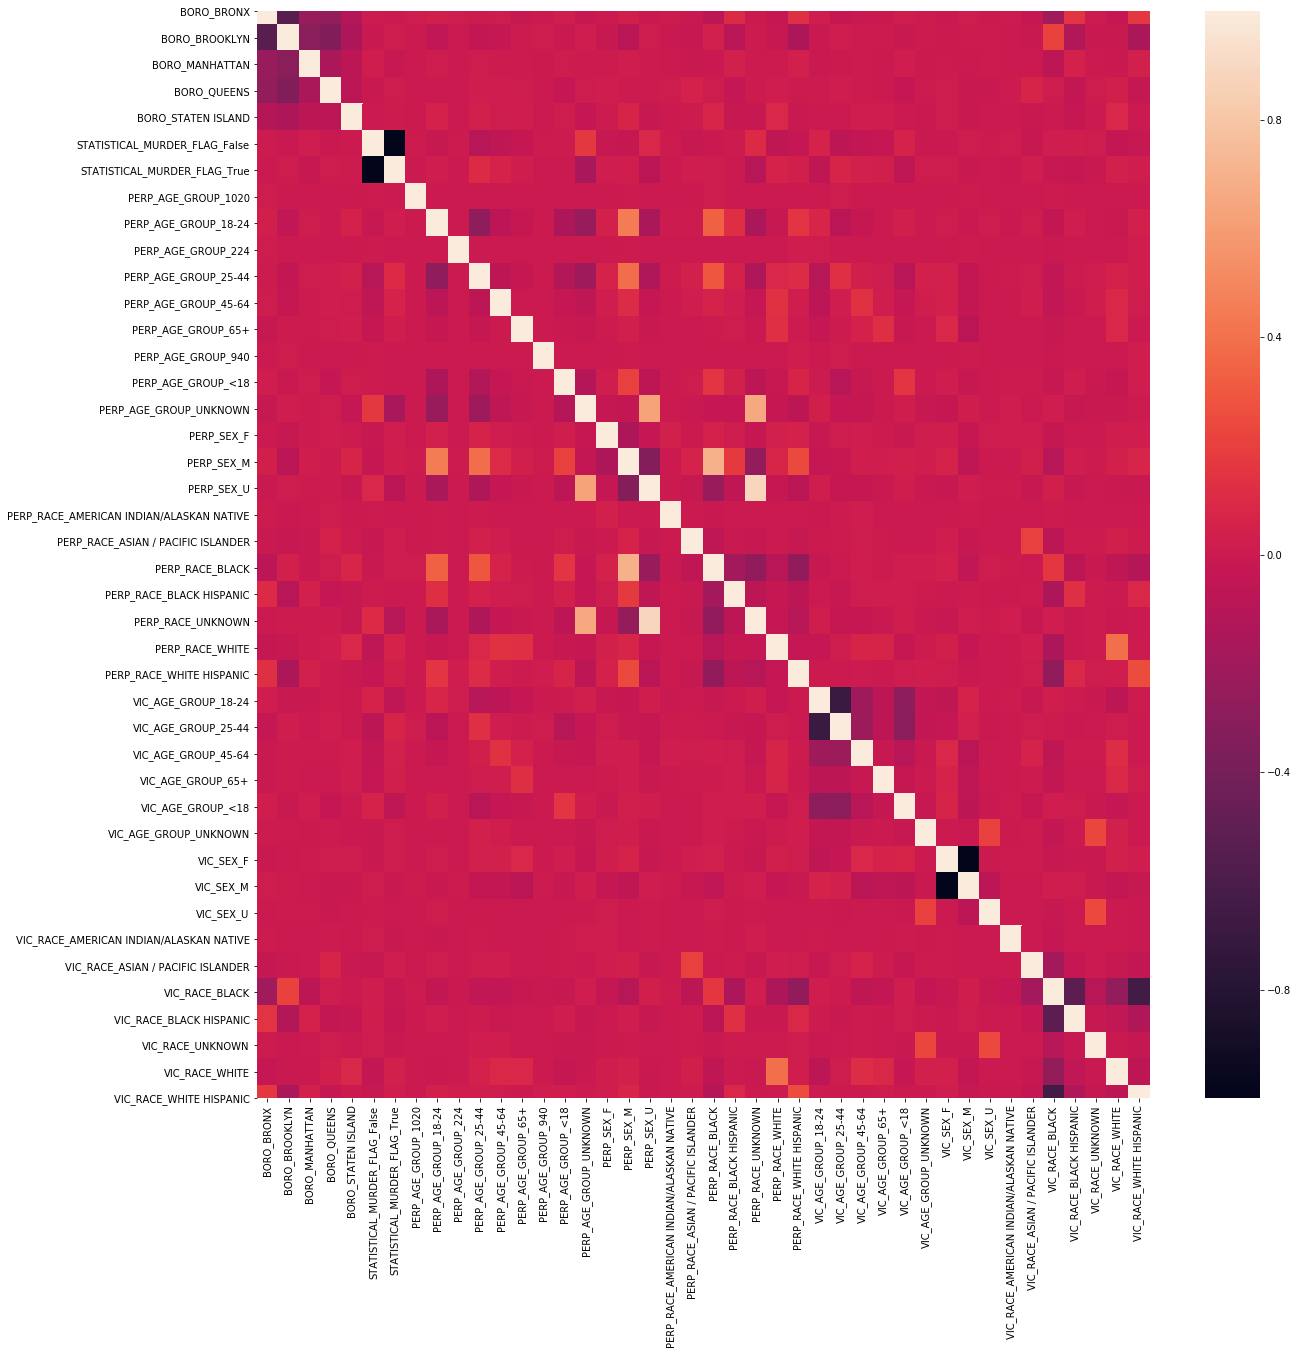

In [50]:
fig, ax = plt.subplots(figsize=(20,20))
#['BORO', 'PRECINCT','STATISTICAL_MURDER_FLAG','PERP_AGE_GROUP','PERP_SEX','PERP_RACE','VIC_AGE_GROUP','VIC_SEX','VIC_RACE']
#drops = ['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'date','JURISDICTION_CODE','LOCATION_DESC', 'X_COORD_CD', 'Y_COORD_CD', 'INCIDENT_KEY', 'Latitude', 'Longitude']

# tailoring based on visualization 
drops = ['date_stamp','Latitude','Longitude']
for c in shooting_df.columns:
    if 'PRECINCT' in c: drops.append(c)

for c in shooting_df.columns:
    if 'JURISDICTION' in c: drops.append(c)        
        
corr = shooting_df.dropna().drop(drops, axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,ax=ax)

### Observations fro Corr Plot

From the corrplot we can make some assessments of the data - specific the perp and victim race and age characteristics. For example is the victim is Female there appears to be a slight positive correction with the Perpetrator being of the Age group 65+.


# Missing Value Imputation

One of the steps in cleaning the data in order to assess and predict might be to impute missing values. A lazy and not recommended approach would be a to equate all of the mission values to the average (or median) of the existing values for numerical data. This approach is extremely error prone and does not account for binary or categorical data.

Another method would be to impute by supervised learning - or predicting the mission values by using neighboring data. The module below outlines the method to use K-Nearest Neighbor regression and classification to impute these mission values.

In [51]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split as tts

def impute_variable(df, var):
    inner_df= df.dropna()
    target = inner_df[var]
    source = inner_df.drop(var, axis=1)
    
    X_train, X_test, y_train, y_test = tts(source, target, test_size=0.30, random_state=1574546920)

    
    clf = knn(n_neighbors=5)
    clf.fit(X_train, y_train)
    pred = clf.predict(df[var])
    
    r_var = [v in df[var] if v is not np.nan else p for v, p in zip(df[var], pred)]
    return r_var

impute_variable(shooting_df, 'PERP_SEX')